# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Plot-the-gsq-vs-gmdsq" data-toc-modified-id="Plot-the-gsq-vs-gmdsq-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot the gsq vs gmdsq</a></div><div class="lev1 toc-item"><a href="#Magnitude-Binnings-for-monochromatic-case" data-toc-modified-id="Magnitude-Binnings-for-monochromatic-case-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Magnitude Binnings for monochromatic case</a></div><div class="lev1 toc-item"><a href="#Curve-Fitting" data-toc-modified-id="Curve-Fitting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Curve Fitting</a></div><div class="lev1 toc-item"><a href="#Create-9-bins-of-magnitude-for-monochromatic-case" data-toc-modified-id="Create-9-bins-of-magnitude-for-monochromatic-case-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Create 9 bins of magnitude for monochromatic case</a></div><div class="lev1 toc-item"><a href="#Fit-linear-equation-to-whole-data-with-given-magnitude-range" data-toc-modified-id="Fit-linear-equation-to-whole-data-with-given-magnitude-range-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Fit linear equation to whole data with given magnitude range</a></div><div class="lev1 toc-item"><a href="#Weight-of-Magnitude-for-Monochromatic-and-Chromatic-Cases" data-toc-modified-id="Weight-of-Magnitude-for-Monochromatic-and-Chromatic-Cases-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Weight of Magnitude for Monochromatic and Chromatic Cases</a></div><div class="lev1 toc-item"><a href="#Create-single-magnitude_weight-column-for-both-mono-and-chro" data-toc-modified-id="Create-single-magnitude_weight-column-for-both-mono-and-chro-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Create single magnitude_weight column for both mono and chro</a></div>

# Introduction
Date: Dec 5, 2019

**Purpose**  
1. Find the weights for g_sq for given magnitude bins using smooth fitting curve.



**Usual Filtering**  
```python
df = df.query('calib_psfCandidate == 0.0')
df = df.query('deblend_nChild == 0.0')
df['ellip'] = np.hypot( df['ext_shapeHSM_HsmShapeRegauss_e1'] ,
                        df['ext_shapeHSM_HsmShapeRegauss_e2'] )
df = df.query('ellip < 2.0') # it was 1.5 before

#select only few columns after filtering:
cols_select = ['base_SdssCentroid_x', 'base_SdssCentroid_y',
                'base_SdssCentroid_xSigma','base_SdssCentroid_ySigma',
                'ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2',
                'base_SdssShape_flux']
df = df[cols_select]        

# drop all nans
df = df.dropna()

# additional columns
df['radius'] =  df.eval(""" ( (ext_shapeHSM_HsmSourceMoments_xx *  ext_shapeHSM_HsmSourceMoments_yy) \
                                          -  (ext_shapeHSM_HsmSourceMoments_xy**2 ) )**0.25 """)
```

**Shape filtering**  
https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_gcr_2_lensing_cuts.ipynb
```python
df = df.query('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3')
df = df.query('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4')
df = df.query('ext_shapeHSM_HsmShapeRegauss_flag== 0.0')
```

**Filter strongly lensed objects**  
- Take the objects with centroids >154 pixels (remove strong lens objects).
```python
# exclude strong lens objects <=154 distance
# The shape of lsst.fits file is 3998,3998 and center is 1699,1699.
df['x_center'] = 1699
df['y_center'] = 1699
df['distance'] = ( (df['x[0]'] - df['x_center'])**2 + (df['x[1]'] - df['y_center'])**2 )**0.5
df = df[df.distance > 154]
```

**Imcat script**  
```bash

# create new columns and cleaning (four files)
lc -C -n fN -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n ellip -n flux -n radius < "${M9T}".txt  |  lc +all 'mag = %flux log10 -2.5 *'  |  cleancat 20  |  lc +all -r 'mag' > "${M9C}".cat


# merge 4 catalogs
mergecats 5 "${MC}".cat "${M9C}".cat "${LC}".cat "${L9C}".cat > ${catalogs}/merge.cat &&
            
            
lc -b +all 
'x = %x[0][0] %x[1][0] + %x[2][0] + %x[3][0] + 4 / %x[0][1] %x[1][1] + %x[2][1] + %x[3][1] + 4 / 2 vector'
'gm = %g[0][0] %g[1][0] + 2 / %g[0][1] %g[1][1] + 2 / 2 vector' 
'gc = %g[2][0] %g[3][0] + 2 / %g[2][1] %g[3][1] + 2 / 2 vector'   
'gmd = %g[0][0] %g[1][0] - 2 / %g[0][1] %g[1][1] - 2 / 2 vector' 
'gcd = %g[2][0] %g[3][0] - 2 / %g[2][1] %g[3][1] - 2 / 2 vector' 
< ${catalogs}/merge.cat > ${final}/final_${i}.cat
```
**Notes**  

final_text.txt is created by imcat program after merging four lsst files (m,m9,l,l9) after cleaning.



# Imports

In [ ]:
import json, os,sys
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

pd.set_option('display.max_columns',200)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [11]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Plot the gsq vs gmdsq

```
g_sq = g00 g00 + g10 g10
gmd_sq = gmd0**2 + gmd1**2

```

In [2]:
!head -2 ../data/cleancat/final_text_cleancat15.txt

#       fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]      mag[0][0]      mag[1][0]      mag[2][0]      mag[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]
               0              0              0              0           5301           5314           5231           5117       88.17075      1847.1934         0.0196         0.0249         0.0227         0.0216           0.02         0.0256       

In [3]:
names = "fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]      mag[0][0]      mag[1][0]      mag[2][0]      mag[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]"
print(names)

fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]      mag[0][0]      mag[1][0]      mag[2][0]      mag[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]


In [4]:
names = ['fN[0][0]','fN[1][0]','fN[2][0]','fN[3][0]',
 'id[0][0]','id[1][0]','id[2][0]','id[3][0]',
 'x[0]','x[1]',
 'errx[0][0]','errx[0][1]','errx[1][0]','errx[1][1]','errx[2][0]',
 'errx[2][1]','errx[3][0]','errx[3][1]',
 'g[0][0]','g[0][1]','g[1][0]','g[1][1]','g[2][0]','g[2][1]','g[3][0]','g[3][1]',
 'ellip[0][0]','ellip[1][0]','ellip[2][0]','ellip[3][0]',
 'flux[0][0]','flux[1][0]','flux[2][0]','flux[3][0]',
 'radius[0][0]','radius[1][0]','radius[2][0]','radius[3][0]',
 'mag[0][0]','mag[1][0]','mag[2][0]','mag[3][0]',
 'gm[0]','gm[1]','gc[0]', 'gc[1]',
 'gmd[0]','gmd[1]','gcd[0]','gcd[1]']


file_path = f'../data/cleancat/final_text_cleancat15.txt'


df = pd.read_csv(file_path,comment='#',engine='python',sep=r'\s\s+',
                 header=None,names=names)

print(df.shape)

# new columns
# df['g_sq'] = df['g[0][0]'] **2 + df['g[1][0]']**2 # only for imcat 00 and 10
# df['gmd_sq'] = df['gmd[0]'] **2 + df['gmd[1]']**2

df['g_sq'] = df['g[0][0]'] **2 + df['g[0][1]']**2
df['gmd_sq'] = df['gmd[0]'] **2 + df['gmd[1]']**2

df['gm_sq'] = df['gm[0]']**2 + df['gm[1]']**2
df['gc_sq'] = df['gc[0]']**2 + df['gc[1]']**2


df.head()

(56861, 50)


,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],ellip[0][0],ellip[1][0],ellip[2][0],ellip[3][0],flux[0][0],flux[1][0],flux[2][0],flux[3][0],radius[0][0],radius[1][0],radius[2][0],radius[3][0],mag[0][0],mag[1][0],mag[2][0],mag[3][0],gm[0],gm[1],gc[0],gc[1],gmd[0],gmd[1],gcd[0],gcd[1],g_sq,gmd_sq,gm_sq,gc_sq
0,0,0,0,0,5301,5314,5231,5117,88.17075,1847.19340,0.0196,0.0249,0.0227,0.0216,0.0200,0.0256,0.0231,0.0220,-0.4253,0.1855,0.2730,-0.3021,-0.4257,0.1904,0.2778,-0.3155,0.463994,0.407177,0.466340,0.420373,79841.4700,82737.3540,80303.9230,83923.9080,5.186953,5.293858,5.267827,5.390682,-12.255571,-12.294254,-12.261842,-12.309714,-0.07615,-0.05830,-0.07395,-0.06255,-0.34915,0.24380,-0.35175,0.25295,0.215290,0.181344,0.009198,0.009381
1,0,0,0,0,3941,3957,3897,3923,3214.45390,930.33603,0.0344,0.0212,0.0331,0.0232,0.0344,0.0212,0.0332,0.0232,0.9068,0.3231,0.7867,0.3391,0.9179,0.3265,0.7956,0.3416,0.962642,0.856671,0.974240,0.865835,33913.5470,34112.9040,33903.5430,34114.7980,4.676457,4.750963,4.675408,4.751770,-11.325933,-11.332297,-11.325613,-11.332357,0.84675,0.33110,0.85675,0.33405,0.06005,-0.00800,0.06115,-0.00755,0.926680,0.003670,0.826613,0.845610
2,0,0,0,0,1301,1310,1323,1312,2652.56650,1772.34480,0.2510,0.1715,0.1663,0.3002,0.2522,0.1715,0.1665,0.3017,0.9614,0.5881,-0.9979,-0.4635,1.0062,0.6076,-1.0206,-0.4729,1.127010,1.100289,1.175422,1.124837,3694.2411,3674.4453,3684.1640,3663.4596,4.161950,4.303319,4.159870,4.301257,-8.918813,-8.912980,-8.915847,-8.909728,-0.01825,0.06230,-0.00720,0.06735,0.97965,0.52580,1.01340,0.54025,1.270152,1.236180,0.004214,0.004588
3,0,0,0,0,3564,3564,3541,3538,2536.84490,712.48793,0.0071,0.0125,0.0071,0.0129,0.0074,0.0129,0.0074,0.0134,-1.0289,0.4499,-1.0196,0.3961,-0.9862,0.4332,-0.9816,0.3755,1.122963,1.093837,1.077150,1.050970,107866.5700,109330.9900,109214.9900,110405.2400,4.848973,4.967938,4.963241,5.096215,-12.582217,-12.596858,-12.595706,-12.607474,-1.02425,0.42300,-0.98390,0.40435,-0.00465,0.02690,-0.00230,0.02885,1.261045,0.000745,1.228017,1.131558
4,0,0,0,0,4634,4659,4569,4615,109.82575,1405.32120,0.3760,0.3919,0.2353,0.2783,0.3803,0.3949,0.2379,0.2831,0.2055,0.1655,-0.1817,-0.0868,0.2052,0.1698,-0.1773,-0.0987,0.263857,0.201368,0.266344,0.202921,3512.8911,3518.9333,3517.0462,3518.1529,4.338535,4.362407,4.374177,4.392268,-8.864162,-8.866028,-8.865445,-8.865787,0.01190,0.03935,0.01395,0.03555,0.19360,0.12615,0.19125,0.13425,0.069621,0.053395,0.001690,0.001458


# Magnitude Binnings for monochromatic case

In [5]:
df['mag_mono'] = (df['mag[0][0]'] + df['mag[1][0]'] ) / 2
df['mag_chro'] = (df['mag[2][0]'] + df['mag[3][0]'] ) / 2

pd.concat( [df['mag_mono'].describe(), df['mag_chro'].describe()], axis=1)

,mag_mono,mag_chro
count,56861.000000,56861.000000
mean,-10.746962,-10.748682
std,1.342916,1.342943
min,-15.454874,-15.455991
25%,-11.746562,-11.747675
50%,-10.421413,-10.423081
75%,-9.690637,-9.692240
max,-7.743323,-7.771729


In [61]:
# df.filter(regex='mag',axis=1).head()

In [23]:
# mag bins
def plot_bin_mag_mono(nbins,show=False):
    df['bins_mag_mono'] = pd.cut(df['mag_mono'],nbins)
    text = df.groupby('bins_mag_mono')['gm_sq'].count().to_string()

    # plot
    fig,ax = plt.subplots(figsize=(12,8))
    df.groupby('bins_mag_mono')['gm_sq'].mean().plot(marker='o',ax=ax)
    plt.xticks(rotation=90,fontsize=18)
    plt.ylabel('gm_sq_mean',fontsize=18)
    plt.xlabel('bin_mag_mono',fontsize=18)
    plt.title(f'gm_sq per magnitude bins with nbins = {nbins}')
    plt.text(0,0.5,text,fontsize=14,va='center')
    plt.ylim(0,1)
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.tight_layout()
        
    plt.savefig(f'images/bin_mag_mono_{nbins}.png')
    
    if show:
        plt.show()
    plt.close()
        
for nbins in range(5,15):
    plot_bin_mag_mono(nbins)

```
![](images/bin_mag_mono_5.png)
![](images/bin_mag_mono_6.png)
![](images/bin_mag_mono_7.png)
![](images/bin_mag_mono_8.png)
![](images/bin_mag_mono_9.png)
![](images/bin_mag_mono_10.png)
![](images/bin_mag_mono_11.png)
![](images/bin_mag_mono_12.png)
![](images/bin_mag_mono_13.png)
![](images/bin_mag_mono_14.png)
```

# Curve Fitting

```
To find the weights
---------------------
ignore first 3 bins
ignore last two bins
i.e. Take only upward going curve.

Then,
f(mag) = 0.1 if mag < 12.8
f(mag) = a*mag + b for upward line

Fit and find the parameters a and b.

Then,
weight = 1 / f(mag)

Then,
weight = weight / total_weight
```
![](images/bin_mag_mono_9.png)

# Create 9 bins of magnitude for monochromatic case

In [25]:
nbins = 9
df['bins_mag_mono'] = pd.cut(df['mag_mono'],nbins)

df9 = df.groupby('bins_mag_mono')['gm_sq'].mean().to_frame()
df9['bins_mean'] = [np.mean(i) for i in df9.index.categories.to_tuples()]

df9 = df9.reset_index()
df9

,bins_mag_mono,gm_sq,bins_mean
0,"(-15.463, -14.598]",0.728204,-15.0305
1,"(-14.598, -13.741]",0.084791,-14.1695
2,"(-13.741, -12.884]",0.071706,-13.3125
3,"(-12.884, -12.028]",0.088878,-12.4560
4,"(-12.028, -11.171]",0.305073,-11.5995
5,"(-11.171, -10.314]",0.502750,-10.7425
6,"(-10.314, -9.457]",0.697041,-9.8855
7,"(-9.457, -8.6]",0.545734,-9.0285
8,"(-8.6, -7.743]",0.236347,-8.1715


In [27]:
# remove first 3 bins with low object counts
# remove last two bins
df9_clipped = df9.loc[~df9.index.isin([0,1,2,7,8])]
df9_clipped

,bins_mag_mono,gm_sq,bins_mean
3,"(-12.884, -12.028]",0.088878,-12.4560
4,"(-12.028, -11.171]",0.305073,-11.5995
5,"(-11.171, -10.314]",0.502750,-10.7425
6,"(-10.314, -9.457]",0.697041,-9.8855


In [72]:
from scipy.optimize import curve_fit


x = df9_clipped['bins_mean'].to_numpy()
y = df9_clipped['gm_sq'].to_numpy()

def func(x, a, b):
    return a*x + b

params, _ = curve_fit(func, x, y)
[aa, bb] = params.round(2)

aa,bb

(0.15, 2.12)

# Fit linear equation to whole data with given magnitude range
To find magnitude range 
```
look at monochromatic case
take nbins = 9
plot magnitude bins vs gm_sq_mean

exclude left and right bins with low object counts
```

In [28]:
# take all the data between -12.4560 to -9.8855 magnitude

df_xy = df.query(""" -12.4560 < mag_mono <  -9.8855 """)[['gm_sq','mag_mono']]

print(df_xy.shape)
df_xy.head()

(29579, 2)


,gm_sq,mag_mono
0,0.009198,-12.274912
1,0.826613,-11.329115
5,0.445224,-11.691620
6,1.016894,-10.738636
8,0.038623,-11.618312


In [62]:
df_xy['mag_mono'].describe()

count    29579.000000
mean       -10.909681
std          0.749264
min        -12.455868
25%        -11.475672
50%        -10.737533
75%        -10.273412
max         -9.885781
Name: mag_mono, dtype: float64

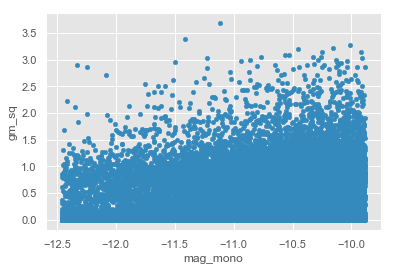

In [61]:
df_xy.plot.scatter(x='mag_mono',y='gm_sq')

In [59]:
from scipy.optimize import curve_fit


x = df_xy['mag_mono'].to_numpy()
y = df_xy['gm_sq'].to_numpy()

def func(x, a, b):
    return a*x + b

params, _ = curve_fit(func, x, y)
[a, b] = params.round(2)

a,b

(0.24, 3.1)

# Weight of Magnitude for Monochromatic and Chromatic Cases

In [8]:
df.filter(regex='mag').head(2)

,mag[0][0],mag[1][0],mag[2][0],mag[3][0],mag_mono,mag_chro,bins_mag_mono
0,-12.255571,-12.294254,-12.261842,-12.309714,-12.274912,-12.285778,"(-12.701, -12.15]"
1,-11.325933,-11.332297,-11.325613,-11.332357,-11.329115,-11.328985,"(-11.599, -11.048]"


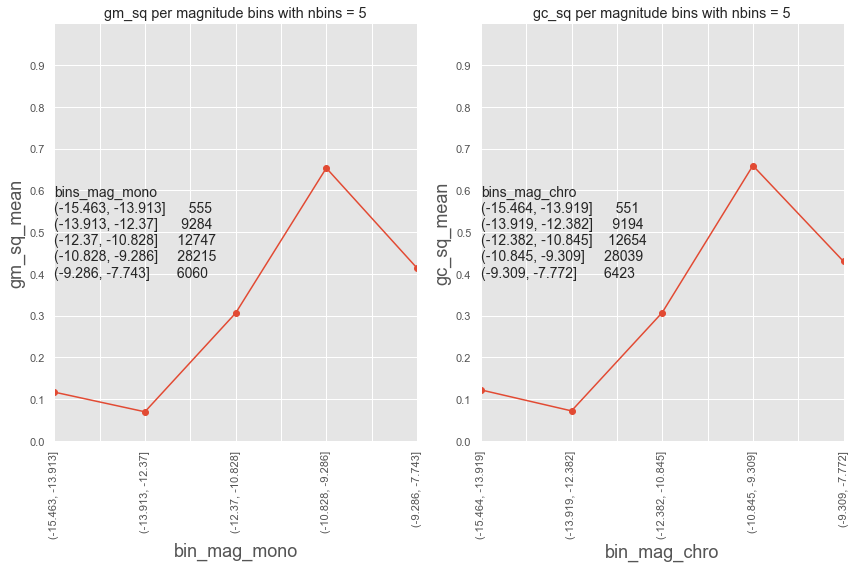

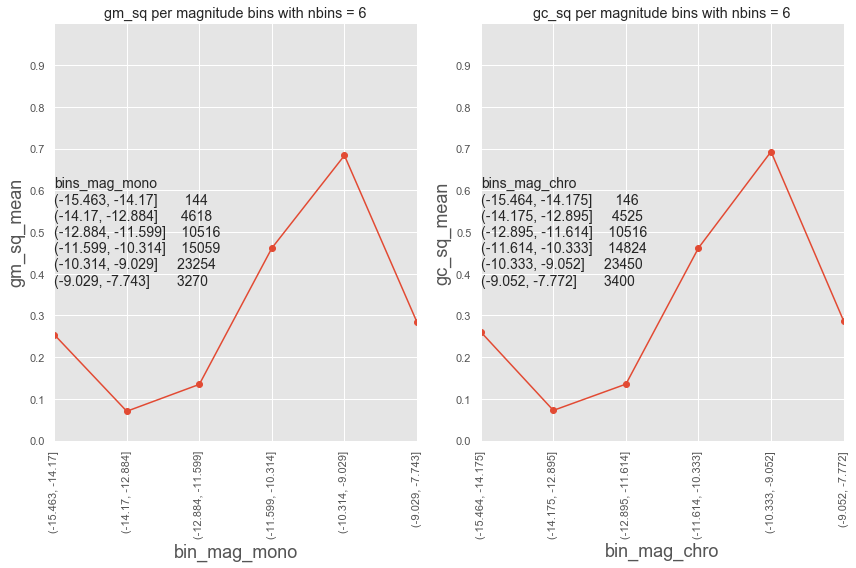

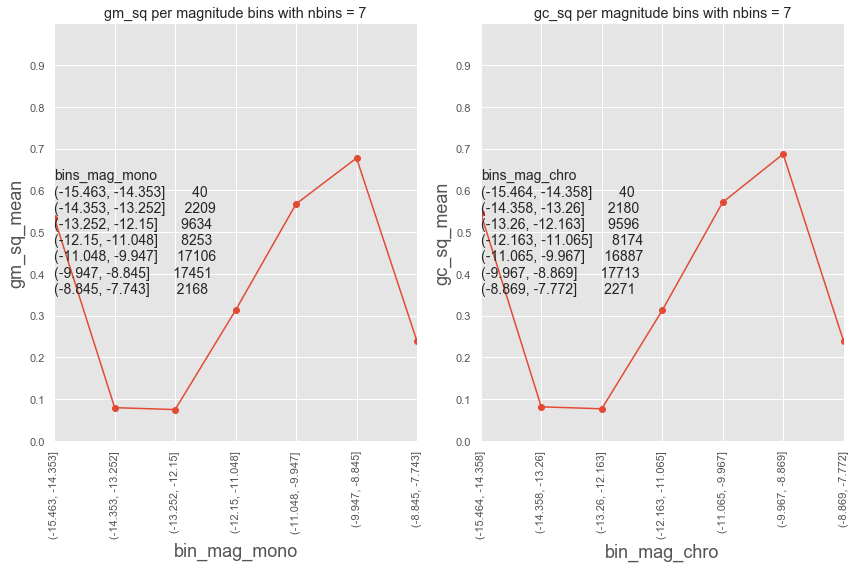

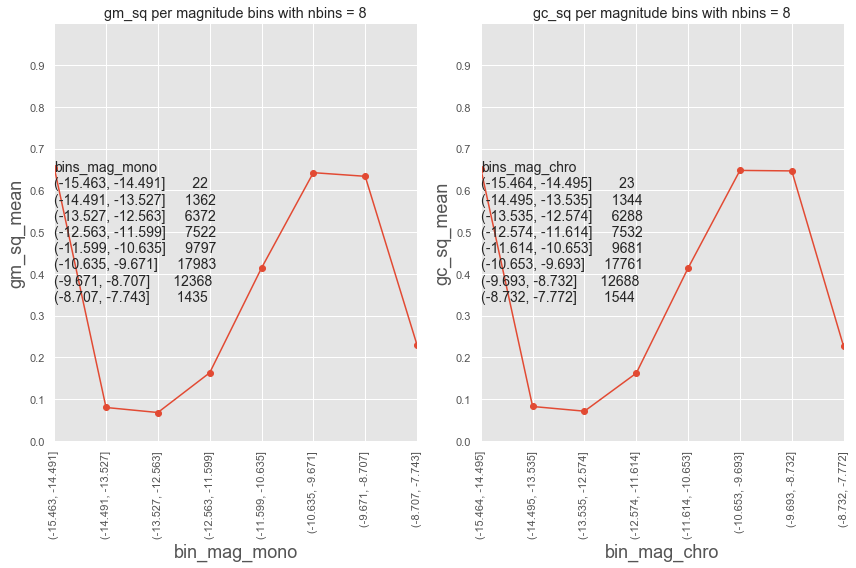

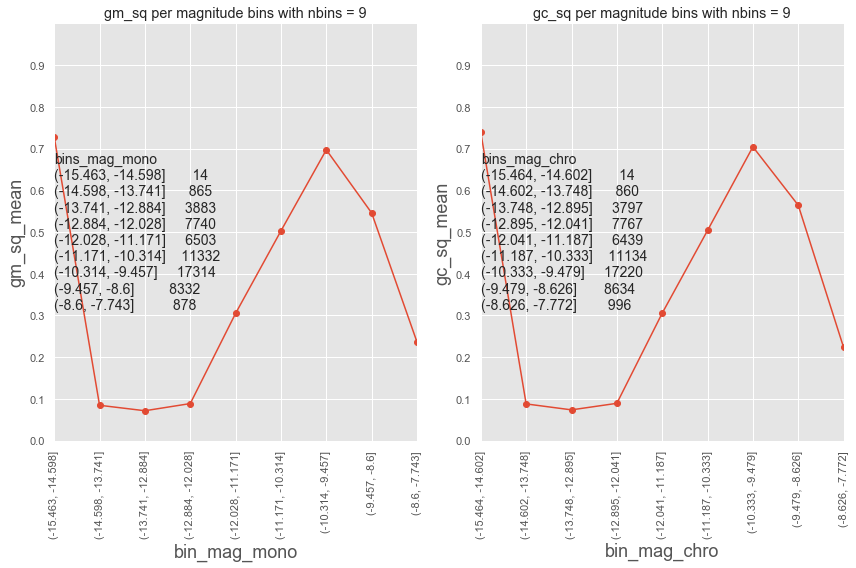

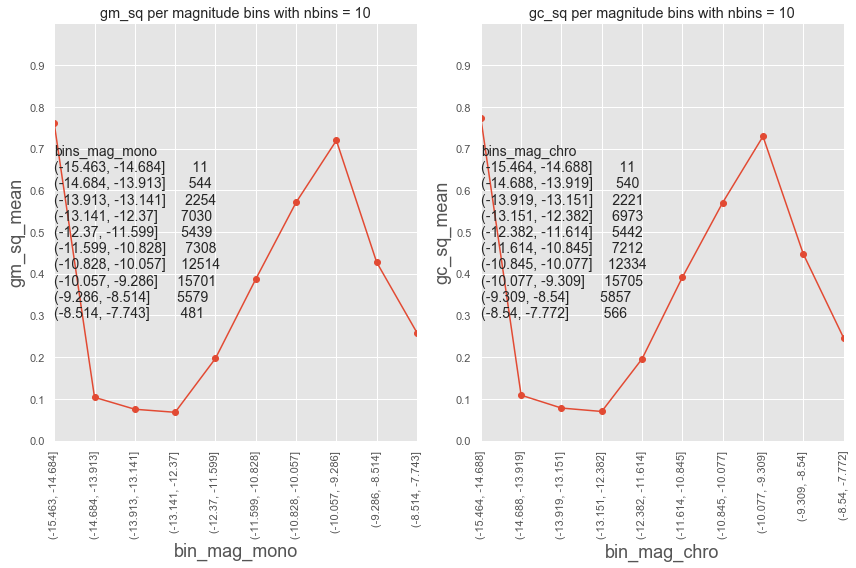

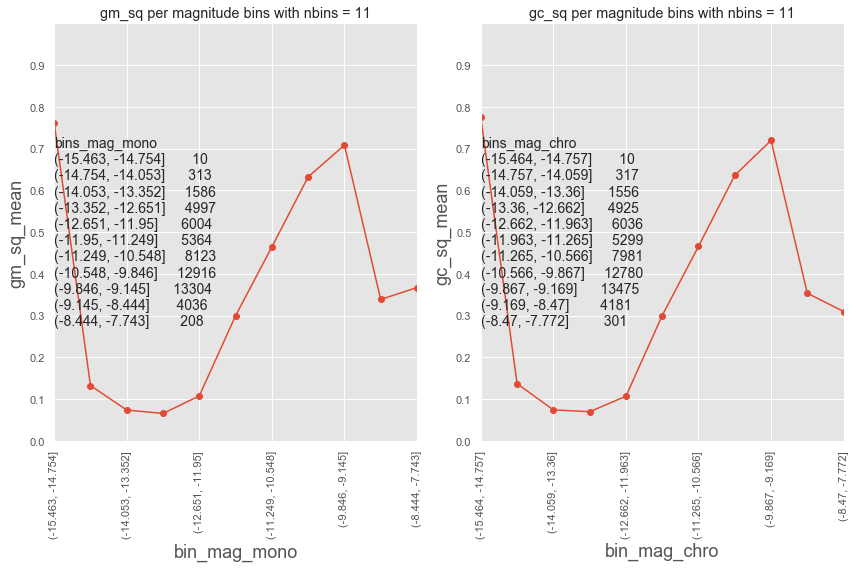

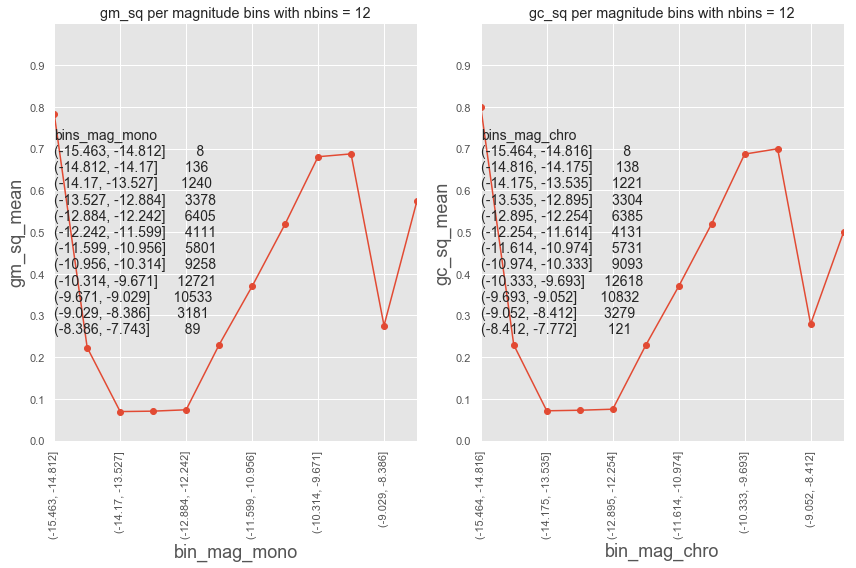

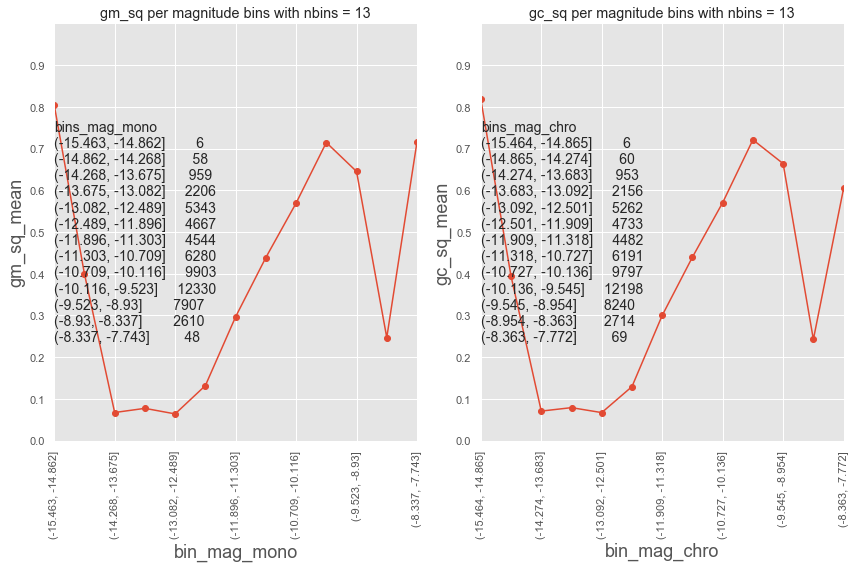

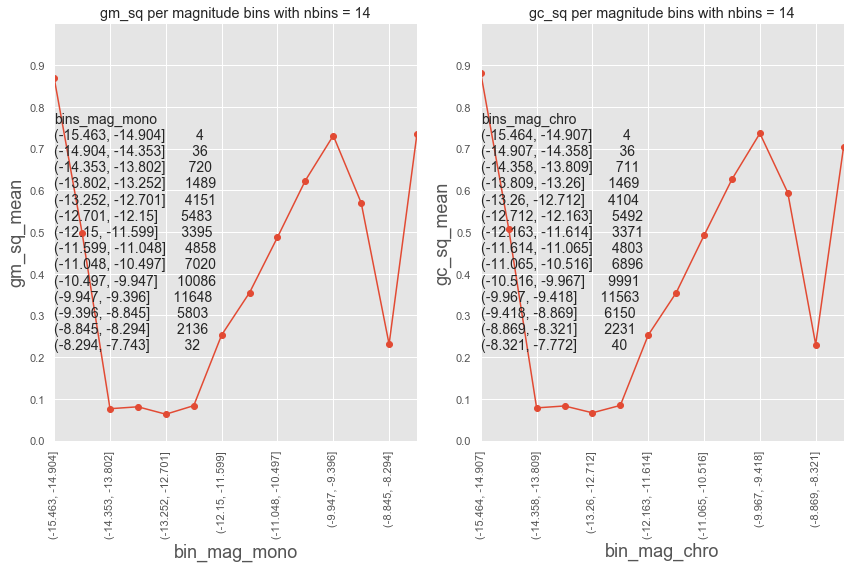

In [22]:
def plot_bin_mag_mono_chro(nbins,show=False):
    df['bins_mag_mono'] = pd.cut(df['mag_mono'],nbins)
    df['bins_mag_chro'] = pd.cut(df['mag_chro'],nbins)
    
    text_mono = df.groupby('bins_mag_mono')['gm_sq'].count().to_string()
    text_chro = df.groupby('bins_mag_chro')['gc_sq'].count().to_string()

    # plot
    fig,ax = plt.subplots(1,2,figsize=(12,8))
    
    # mono
    df.groupby('bins_mag_mono')['gm_sq'].mean().plot(marker='o',ax=ax[0])
    ax[0].tick_params(axis='x', rotation=90)
    ax[0].set_ylabel('gm_sq_mean',fontsize=18)
    ax[0].set_xlabel('bin_mag_mono',fontsize=18)
    ax[0].set_title(f'gm_sq per magnitude bins with nbins = {nbins}')
    ax[0].text(0,0.5,text_mono,fontsize=14,va='center')
    ax[0].set_ylim(0,1)
    ax[0].set_yticks(np.arange(0, 1, step=0.1))
    
    # chro
    df.groupby('bins_mag_chro')['gc_sq'].mean().plot(marker='o',ax=ax[1])
    ax[1].tick_params(axis='x', rotation=90)
    ax[1].set_ylabel('gc_sq_mean',fontsize=18)
    ax[1].set_xlabel('bin_mag_chro',fontsize=18)
    ax[1].set_title(f'gc_sq per magnitude bins with nbins = {nbins}')
    ax[1].text(0,0.5,text_chro,fontsize=14,va='center')
    ax[1].set_ylim(0,1)
    ax[1].set_yticks(np.arange(0, 1, step=0.1))
    
    plt.tight_layout()

    if show:
        plt.show()
    plt.close()

for nbins in range(5,15):
    plot_bin_mag_mono_chro(nbins,show=True)

In [43]:
# Monochromatic case

In [55]:
# df['mag_mono'].plot.hist()

In [58]:
from scipy.optimize import curve_fit

# look at case when nbins = 9 and when the curve is going up
mag_low_nbins9 = (-12.884-12.028) / 2
mag_high_nbins9 = (-10.314-9.457) / 2

xcol = 'mag_mono'
ycol = 'gm_sq'

x = df.query("""  @mag_low_nbins9 < mag_mono <  @mag_high_nbins9  """)[xcol].to_numpy()
y = df.query("""  @mag_low_nbins9 < mag_mono <  @mag_high_nbins9  """)[ycol].to_numpy()

def func(x, a, b):
    return a*x + b

params, _ = curve_fit(func, x, y)
[a, b] = params.round(2)

print(f'magnitude ranges for mono: {mag_low_nbins9}, {mag_high_nbins9}')
print(f'fitting params   for mono: {a}, {b}' )

magnitude ranges for mono: -12.456, -9.8855
fitting params   for mono: 0.24, 3.1


In [46]:
# Chromatic Case

In [54]:
# df['mag_chro'].plot.hist()

In [62]:
from scipy.optimize import curve_fit

# look at case when nbins = 9 and when the curve is going up
mag_low_nbins9 = (-12.895-12.041) / 2
mag_high_nbins9 = (-10.333-9.479) / 2

xcol = 'mag_chro'
ycol = 'gc_sq'

x = df.query("""  @mag_low_nbins9 < mag_chro <  @mag_high_nbins9  """)[xcol].to_numpy()
y = df.query("""  @mag_low_nbins9 < mag_chro <  @mag_high_nbins9  """)[ycol].to_numpy()

def func(x, a, b):
    return a*x + b

params, _ = curve_fit(func, x, y)
[a, b] = params.round(2)

print(f'magnitude ranges for chro: {mag_low_nbins9}, {mag_high_nbins9}')
print(f'fitting params   for chro: {a}, {b}' )

magnitude ranges for chro: -12.468, -9.905999999999999
fitting params   for chro: 0.25, 3.13


# Create single magnitude_weight column for both mono and chro

In [60]:
def magnitude_weight(mag):
    if mag < -12.46:
        return 1/ 0.1
    
    else:
        return 1/ (a*mag + b)

df['weight_magnitude'] = df['mag_mono'].apply(magnitude_weight)

df['weight_magnitude'] = df['weight_magnitude'] / df['weight_magnitude'].mean() # normalize by mean

df.iloc[:2,-5:]

,mag_mono,mag_chro,bins_mag_mono,bins_mag_chro,weight_magnitude
0,-12.274912,-12.285778,"(-12.884, -12.028]","(-12.712, -12.163]",3.563599
1,-11.329115,-11.328985,"(-12.028, -11.171]","(-11.614, -11.065]",0.733399
